In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import os, os.path 
import numpy 
import pickle
from glob import glob

"""Change to the data folder"""
new_path = "./new_train/new_train/"

# number of sequences in each dataset
# train:205942  val:3200 test: 36272 
# sequences sampled at 10HZ rate

### Create a dataset class 

In [2]:
class ArgoverseDataset(Dataset):
    """Dataset class for Argoverse"""
    def __init__(self, data_path: str, transform=None):
        super(ArgoverseDataset, self).__init__()
        self.data_path = data_path
        self.transform = transform

        self.pkl_list = glob(os.path.join(self.data_path, '*'))
        self.pkl_list.sort()
        
    def __len__(self):
        return len(self.pkl_list)

    def __getitem__(self, idx):

        pkl_path = self.pkl_list[idx]
        with open(pkl_path, 'rb') as f:
            data = pickle.load(f)
            
        if self.transform:
            data = self.transform(data)

        return data


# intialize a dataset
val_dataset  = ArgoverseDataset(data_path=new_path)

### Create a loader to enable batch processing

In [3]:
batch_sz = 4

def my_collate(batch):
    """ collate lists of samples into batches, create [ batch_sz x agent_sz x seq_len x feature] """
    inp = [numpy.dstack([scene['p_in'], scene['v_in']]) for scene in batch]
    out = [numpy.dstack([scene['p_out'], scene['v_out']]) for scene in batch]
    track_ids = [scene['track_id'] for scene in batch]
    agent_ids = [scene['agent_id'] for scene in batch]
    car_mask = [scene['car_mask'] for scene in batch]
    inp = torch.LongTensor(inp)
    out = torch.LongTensor(out)
    car_mask = torch.LongTensor(car_mask)
    return [inp, out, track_ids, agent_ids, car_mask]

val_loader = DataLoader(val_dataset,batch_size=batch_sz, shuffle = False, collate_fn=my_collate, num_workers=0)

### Visualize the batch of sequences

In [4]:
import matplotlib.pyplot as plt
import random
from tqdm.notebook import tqdm

agent_id = 0

def show_sample_batch(sample_batch, agent_id):
    """visualize the trajectory for a batch of samples with a randon agent"""
    inp, out = sample_batch
    batch_sz = inp.size(0)
    agent_sz = inp.size(1)
    
    fig, axs = plt.subplots(1,batch_sz, figsize=(15, 3), facecolor='w', edgecolor='k')
    fig.subplots_adjust(hspace = .5, wspace=.001)
    axs = axs.ravel()   
    for i in range(batch_sz):
        axs[i].xaxis.set_ticks([])
        axs[i].yaxis.set_ticks([])
        
        # first two feature dimensions are (x,y) positions
        axs[i].scatter(inp[i, agent_id,:,0], inp[i, agent_id,:,1])
        axs[i].scatter(out[i, agent_id,:,0], out[i, agent_id,:,1])

x_in = []
y_in = []
x_out = []
y_out = []
vel_x_in = []
vel_x_out = []
vel_y_in = []
vel_y_out = []

for i_batch, sample_batch in enumerate(tqdm(val_loader)):
    inp, out, track_ids, agent_ids, car_mask = sample_batch
    
    if i_batch >= 51485:
        continue
    
    for i in range(batch_sz):
        scene = inp[i]
        
        for j in range(scene.shape[0]):
            if car_mask[i][j][0] == 1:
                x_in.extend([x.item() for x in inp[i,j,:,0]])
                y_in.extend([y.item() for y in inp[i,j,:,1]])
                x_out.extend([x.item() for x in out[i,j,:,0]])
                y_out.extend([y.item() for y in out[i,j,:,1]])
                vel_x_in.extend([x.item() for x in inp[i,j,:,2]])
                vel_y_in.extend([y.item() for y in inp[i,j,:,3]])
                vel_x_out.extend([x.item() for x in out[i,j,:,2]])
                vel_y_out.extend([y.item() for y in out[i,j,:,3]])
            else:
                break
    
    
    #show_sample_batch(sample_batch, agent_id)

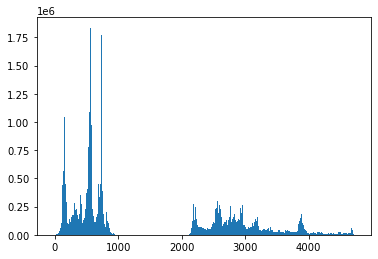

In [5]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=x_in, bins='auto')
plt.show()

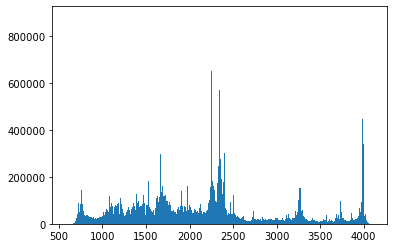

In [6]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=y_in, bins='auto')
plt.show()

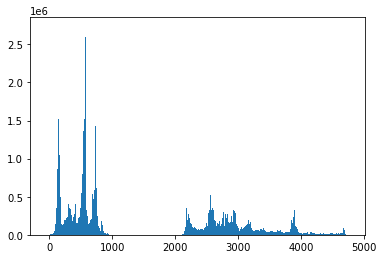

In [7]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=x_out, bins='auto')
plt.show()

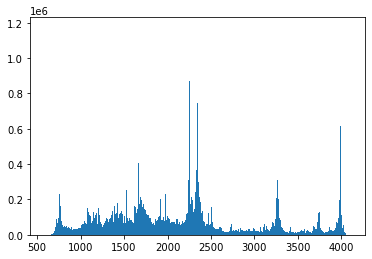

In [8]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=y_out, bins='auto')
plt.show()

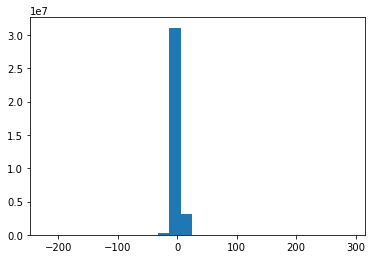

In [9]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=vel_x_in, bins='auto')
plt.show()

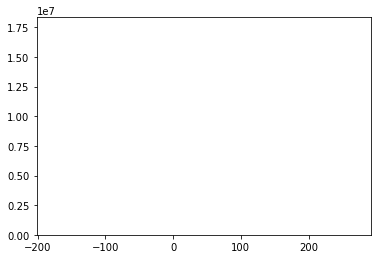

In [10]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=vel_y_in, bins='auto')
plt.show()

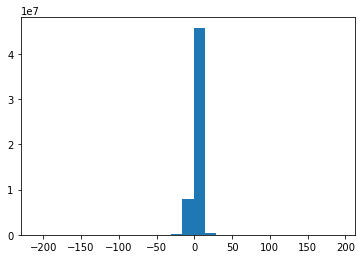

In [11]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=vel_x_out, bins='auto')
plt.show()

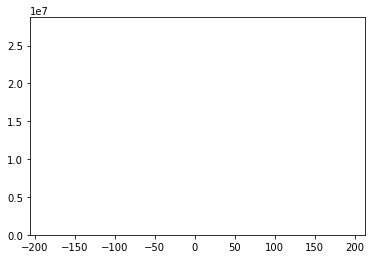

In [12]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=vel_y_out, bins='auto')
plt.show()